# Coffee Shop Customer Traffic Prediction
A Data Science Project Report <br>
June 2020<br>
Edwin Sutrisno

## Introduction/Business Problem

“Location, location, location” is the three-word mantra we often hear when considering how to make our investment run for the money. In this article, we look at a problem of deciding the best location to open a coffee shop so that it has the highest chance of getting high customer traffic. We know that location is important, but what factors specifically make a location a good location. To answer that question, we will study some data collected from the most successful coffee shops in West Kuala Lumpur area and try to use a machine learning technique to extract the driving factors behind their success.

## Data

The main source of the data being used for this study is obtained from the Foursquare's API called Places. From the places API, we obtained locations of several successful coffee shops that become the subject of our study, their customer rating count to represent their traffic, and their neighboring venues. The location of interest in this study is the West Kuala Lumpur area. Because I am a local resident, I can determine that the most successful names for coffee shop in the city are Starbucks and Coffee Bean & Tea Leaf. These two brands will serve as our main subjects.

The data gathering process is broken down into these 3 steps:
1. Get all "Starbucks" and "Coffee Bean & Tea Leaf" locations within 4 km radius from a coordinate in West Kuala Lumpur, Malaysia area (latitude 3.1871 and longitude 101.6276)
2. Get their customer ratings
3. Get their nearby venues within 120 m radius

With the three pieces of information above, we can start grouping locations for their levels of business traffic as marked by their customer rating count and the categories of venue that are nearby those locations. We will build a regression model to predict customer traffic as "low, medium, or high" based on features of the count of venues of different categories. Hopefully, we can identify characteristic neighbors that support a high-selling coffee shop.

In [1]:
# Import the python libraries needed
from configparser import ConfigParser
import pandas as pd
import numpy as np
import folium
import requests
import pickle
from pandas.io.json import json_normalize
from sklearn import tree, metrics
from sklearn.model_selection import LeaveOneOut
from matplotlib import pyplot as plt

In [2]:
# Load the Foursquare Client ID and Secret to access Foursquare's API
creds = ConfigParser()
creds.read(filenames='foursquare_creds.env')
CLIENT_ID = creds['CREDENTIALS']['CLIENT_ID']
CLIENT_SECRET = creds['CREDENTIALS']['CLIENT_SECRET']
API_VER = '20200501'
del creds

In [3]:
# Create a function to search for coffee venues in Foursquare and return a dataframe of the venues found:
def find_coffee(shopname:str, coord:tuple):
    """
    Find coffee shops using the search API within 4000 m radius.
    Return: DataFrame
    """
    url = 'https://api.foursquare.com/v2/venues/search'
    params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, v=API_VER,
                  ll='{},{}'.format(coord[0], coord[1]),
                  query=shopname,
                  radius=4000,
                  limit=100)
    query = requests.get(url=url, params=params).json()
    del url, params
    
    # Convert into DataFrame
    coffee = json_normalize(query['response']['venues'])
    coffee.columns = [col.split('.')[-1] for col in coffee.columns] # shorten column names
    
    # Extract Category
    categ_exist = coffee['categories'].apply(lambda x: len(x) > 0)
    coffee = coffee.loc[categ_exist]
    del categ_exist
    coffee['category1'] = [x[0]['icon']['prefix'].split('/')[5] for x in coffee['categories'].tolist()]
    coffee['category2'] = [x[0]['icon']['prefix'].split('/')[6] for x in coffee['categories'].tolist()]
    
    # Select columns
    column_selection = ['name', 'distance', 'category1', 'category2', 'neighborhood', 'address', 'lat', 'lng', 'id']
    coffee = coffee[column_selection]
    
    # Remove venues that are not coffess shop or cafe
    is_coffee = coffee['category2'].isin(['coffeeshop_', 'cafe_'])
    coffee = coffee.loc[is_coffee]
    
    # Remove duplicate locations
    coffee['lat'] = coffee['lat'].round(4)
    coffee['lng'] = coffee['lng'].round(4)
    coffee.drop_duplicates(subset=['lat', 'lng'], inplace=True)
    coffee.reset_index(drop=True, inplace=True)
    return coffee

In this study we are interested in analyzing neighborhoods in the West of Kuala Lumpur city, Malaysia. Let's define the coordinate of our search:

In [4]:
COORD = (3.1871, 101.6276) # center of search location

We can view this location on a map using Folium.

In [5]:
klmap = folium.Map(location=COORD, zoom_start=13)
folium.Marker(COORD).add_to(klmap)
klmap

In case you are viewing this notebook on GitHub and the folium map is not appearing, here is a saved snapshot of the map:
!["kl map"](kl_map.JPG)

After defining the center of search location we find the nearby Starbucks and Coffee Bean locations using the Foursquare's "search" API embedded into the find_coffee function defined above.

In [6]:
stbx = find_coffee('starbucks', COORD)
stbx.head(5)

,name,distance,category1,category2,neighborhood,address,lat,lng,id
0,Starbucks,849,food,coffeeshop_,NaN,Kepong Village Mall,3.1926,101.6329,53bcab74498e7e4a348ba0f9
1,Starbucks Reserve,66,food,coffeeshop_,The Waterfront,"GF-03, The Waterfront",3.1869,101.6282,5a20e400a8eb607c63dfe67a
2,Starbucks,3219,food,coffeeshop_,NaN,AEON Metro Prima Shopping Centre,3.2138,101.6388,4b5713d9f964a5207e2528e3
3,Starbucks,3763,food,coffeeshop_,Mutiara Damansara,The Curve,3.1575,101.6113,4b0d1050f964a520894323e3
4,Starbucks,4452,food,coffeeshop_,NaN,1 Utama Shopping Centre,3.1488,101.6160,53ace690498ee1246590366b


In [7]:
cobean = find_coffee('coffee bean & tea leaf', COORD)
cobean.head(5)

,name,distance,category1,category2,neighborhood,address,lat,lng,id
0,The Coffee Bean & Tea Leaf,58,food,coffeeshop_,"Desa ParkCity, Kuala Lumpur, Kuala Lumpur","Lot No. GF-09, Ground Level",3.1866,101.6278,4b251ac8f964a520516c24e3
1,The Coffee Bean & Tea Leaf,1734,food,coffeeshop_,NaN,NaN,3.1972,101.6157,58097c7cd67c32945bf46a86
2,The Coffee Bean & Tea Leaf,832,food,coffeeshop_,Plaza Arkadia,"A-G-11(Block A), Plaza Arkadia. No,3 Jalan Int...",3.1858,101.6350,5930087d4acb192f93dd827f
3,The Coffee Bean & Tea Leaf,3766,food,coffeeshop_,NaN,The Curve,3.1571,101.6119,4b46fa8df964a520282a26e3
4,The Coffee Bean & Tea Leaf,3586,food,coffeeshop_,Mont Kiara,"Verandah No.6 & Terrace B, G-Floor, Shoplex Mo...",3.1671,101.6529,4c1100463ce120a106ee081c


To combine the results from the two dataframes, we create a new dataframe called coffee:

In [8]:
coffee = pd.concat([stbx, cobean], ignore_index=True)

Because we are trying to predict customer traffic, we also need to get the data of customer ratings. To do that, we use Foursquare's "venue" API of querying the details of a venue given its id. One of the returned keys that is important to us is the "ratingSignals" which can indicates how often people visited that venue. Of course, using this feature does not guarantee that it is 100% accurate. For example, people may visit but not rate the venue. So, this is going to be a rough approximation and it is the only data available from Foursquare.

In [9]:
ratings = []
for ii in range(coffee.shape[0]):
    venue_id = coffee.loc[ii, 'id']
    url = 'https://api.foursquare.com/v2/venues/{}'.format(venue_id)
    params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, v=API_VER)
    query = requests.get(url=url, params=params).json()
    try:
        rating = json_normalize(query['response']['venue'])[['id', 'rating', 'ratingSignals']]
    except:
        rating = pd.DataFrame({'id':venue_id, 'rating':-1, 'ratingSignals':-1}, index=[ii])
    ratings.append(rating)
    del query, rating, url, params, venue_id
del ii
ratings = pd.concat(ratings, axis=0)
coffee = coffee.merge(ratings, on='id')
del ratings
coffee.head(8)

,name,distance,category1,category2,neighborhood,address,lat,lng,id,rating,ratingSignals
0,Starbucks,849,food,coffeeshop_,NaN,Kepong Village Mall,3.1926,101.6329,53bcab74498e7e4a348ba0f9,7.3,73
1,Starbucks Reserve,66,food,coffeeshop_,The Waterfront,"GF-03, The Waterfront",3.1869,101.6282,5a20e400a8eb607c63dfe67a,8.0,22
2,Starbucks,3219,food,coffeeshop_,NaN,AEON Metro Prima Shopping Centre,3.2138,101.6388,4b5713d9f964a5207e2528e3,7.1,282
3,Starbucks,3763,food,coffeeshop_,Mutiara Damansara,The Curve,3.1575,101.6113,4b0d1050f964a520894323e3,7.9,538
4,Starbucks,4452,food,coffeeshop_,NaN,1 Utama Shopping Centre,3.1488,101.6160,53ace690498ee1246590366b,7.5,122
5,Starbucks,3754,food,coffeeshop_,NaN,"22, Jalan 25/70A Desa Sri Hartamas",3.1624,101.6506,4dd47aa9814dc3d020774257,7.2,315
6,Starbucks,3805,food,coffeeshop_,NaN,IPC Shopping Centre,3.1569,101.6116,4b0e8c7bf964a520625823e3,7.2,241
7,Starbucks,3826,food,coffeeshop_,NaN,Solaris Mont Kiara,3.1753,101.6599,51ca7e3e498e5923008ca451,7.6,127


After getting the data, I did a manual check and found that Foursqure returned many false locations where the venues don't actually exist at the given coordinates. Some venues were duplicated locations but of different id's such that they seemed to be different venues. Simple but laborious Google Maps search can give us the answer if a venue is valid or not. There was no hard rule to automate the data cleaning process. 

I saved the clean dataset into a CSV file that can be loaded as below.

In [10]:
coffee = pd.read_csv('CoffeeDataframeClean.csv', index_col=0)
print('Number of rows =', len(coffee))

Number of rows = 22


Let's visualize again on the map, but this time with all of the coffee shop locations shown.

In [11]:
for lat, lng in zip(coffee['lat'], coffee['lng']):
    folium.CircleMarker((lat, lng), radius=5, color='red').add_to(klmap)
klmap

In case you are viewing this notebook on GitHub and the folium map is not appearing, here is a saved snapshot of the map:
!["coffee map"](coffee_map.JPG)

# Methodology

In the previous section, we collected data of coffee shops and their number of customer ratings (i.e. customer traffic). That dataset established our prediction target. The next step to build a model is to define our predictive features. In this study, we are going to build our features from the types of venues that are adjacent to the coffee shops. We are working on a hypothesis that certain types of venues and the number of them may promote traffic to our coffee business.

To get the nearby venues and their categories, we use the Foursquare's "explore" API.

### Build the Features

In [12]:
# Function to "explore" venues that are nearby a coffee location
def find_nearby(coord:tuple):
    """
    Find nearby venues using API explore.
    Return:
        nearby : DataFrame
    """
    url = 'https://api.foursquare.com/v2/venues/explore'
    nearby = []
    for section in ['food', 'drinks', 'shops', 'arts', 'outdoors', None]:
        print('Finding section', section)
        params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, v=API_VER,
                      ll='{},{}'.format(coord[0], coord[1]),
                      section=section, radius=120, limit=200)
        query = requests.get(url=url, params=params).json()
        nearby_sec = [x['venue'] for x in query['response']['groups'][0]['items']]
        if not(nearby_sec):
            print('No venues found.')
            continue
        nearby_sec = [{'name':x['name'], 'id':x['id'], 'category_url':x['categories'][0]['icon']['prefix']} for x in nearby_sec]
        nearby_sec = json_normalize(nearby_sec)
        #nearby_sec = json_normalize([x['venue'] for x in query['response']['groups'][0]['items']])
        #nearby_sec.columns = [colname.split('.')[-1] for colname in nearby_sec.columns]

        nearby_sec['category1'] = [x.split('/')[5] for x in nearby_sec['category_url'].tolist()]
        nearby_sec['category2'] = [x.split('/')[6] for x in nearby_sec['category_url'].tolist()]
        nearby_sec = nearby_sec[['name', 'category1', 'category2', 'id']]
        nearby.append(nearby_sec)
        del params, query, nearby_sec
    del section, url
    print('Merging all results.')
    nearby = pd.concat(nearby, axis=0, ignore_index=True, sort=False)
    nearby.drop_duplicates(subset='id', inplace=True)
    nearby.reset_index(drop=True)
    return nearby

We write a for loop that calls the above function to search for nearby venues for every coffee location in our dataset. Then the results are appended into a dictionary.

neighbors = []
for ii in coffee.index:
    print(ii)
    coord = (coffee.loc[ii, 'lat'], coffee.loc[ii, 'lng'])
    print('Find nearby', coord)
    nearby = find_nearby(coord)
    neighbors.append({'coffee_id': coffee.loc[ii, 'id'],
                      'neighbors': nearby})
    del nearby
del ii

I ran the above for loop and it was a bit time consuming to get the results and sometimes Foursquare would hang up returning an error. To save your time in reading this report, I saved the results into a pickle file which we can load in the following code:

In [13]:
neighbors = pickle.load(open('Neighbors.pkl', 'rb'))

Let me show you a little bit how the "neighbors" dataset is structured. It is a list where each item in the list contains the neighbors of a coffee shop. Because we have 22 coffee shops, the length of the list is also 22.

In [14]:
print('Neighbors data type =', type(neighbors))
print('List length =', len(neighbors))
print('Dictionary inside the list contains keys', neighbors[0].keys())

Neighbors data type = <class 'list'>
List length = 22
Dictionary inside the list contains keys dict_keys(['coffee_id', 'neighbors'])


In [15]:
#The nearby neighbors data is a Pandas dataframe with the venue's name and category
print('Coffee shop id', neighbors[0]['coffee_id'], 'has', len(neighbors[0]['neighbors']), 'neighbors.')
print('Here are the first 7 neighbors of this coffee shop:')
neighbors[0]['neighbors'].head(7)

Coffee shop id 53ace690498ee1246590366b has 155 neighbors.
Here are the first 7 neighbors of this coffee shop:


,name,category1,category2,id
0,Indulge,food,diner_,5282471f498edd6f657331a8
1,ICHIRO Sushi Bar,food,sushi_,4fc092e8e4b0f6b4ed9c26db
2,Garrett Popcorn,food,snacks_,5759683acd109dccba6aa08f
3,Tonkatsu by Ma Maison,food,japanese_,50e685e47ab45e59eef716b7
4,The Fish Bowl,food,default_,590025ee6fd6262556826ce6
5,Seaweed Club,food,snacks_,50e69d2ce4b07895f2a3db49
6,KOM'S by KomPassion,food,thai_,5b4db4a090d1ed002cd9bcb2


With the neighbors dataset, we identify all the unique categories that exist in the data set. Here we are only interested in getting the category1 because if we include category2, the number of features will get out of hand. We only have 22 coffee shops, so we want to keep the feature table from getting too wide.

In [16]:
all_cats = []
for nb in neighbors:
    cats = nb['neighbors'][['category1']].drop_duplicates()
    all_cats.append(cats)
all_cats = pd.concat(all_cats)
all_cats.drop_duplicates(inplace=True)
all_cats.sort_values(by='category1', inplace=True)
all_cats.reset_index(drop=True, inplace=True)
del cats, nb

In [17]:
# The neigbhor categories are:
print(all_cats)

            category1
0  arts_entertainment
1            building
2           education
3                food
4           nightlife
5      parks_outdoors
6               shops
7              travel


Using the available categories above, we develop a feature table which counts the number of venues for each category.

In [18]:
#%% Create Features of Category Venue Count
features = pd.DataFrame(data=0, columns=all_cats['category1'].unique(), index=coffee['id'])
for nb in neighbors:
    coffee_id = nb['coffee_id']
    cat1s = nb['neighbors']['category1'].unique()
    for cat1 in cat1s:
        features.loc[coffee_id, cat1] = (nb['neighbors']['category1'] == cat1).sum()
    del cat1s, cat1, coffee_id
del nb

Here is our features table:

In [19]:
features.head(5)

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
id,,,,,,,,
53ace690498ee1246590366b,7,4,0,38,4,3,99,0
4b61623ef964a520b0112ae3,10,4,1,28,4,5,102,0
533a4b93498ea0140dda4c88,6,3,0,17,12,1,27,0
4b0e8c7bf964a520625823e3,5,2,0,48,0,3,104,2
4b0d1050f964a520894323e3,5,4,0,51,1,5,105,2


### Build the Target Variable

In the previous section, we created a features table that will be used to train a classification model. Now, let's define our target which is the rating count obtained from before.

In [20]:
# Create the target variable
venue_ratings = pd.Series(data=coffee['ratingSignals'].values, index=coffee['id'], name='ratingCount')
print('Target variable:')
venue_ratings.head(5)

Target variable:


id
53ace690498ee1246590366b    121
4b61623ef964a520b0112ae3    622
533a4b93498ea0140dda4c88     93
4b0e8c7bf964a520625823e3    241
4b0d1050f964a520894323e3    538
Name: ratingCount, dtype: int64

Because the rating count is somewhat a broad approximation and it has no defined upper limit, it is not appropriate to use the raw values to define how busy a coffee shop is. To normalize the data, we create 3 level map of traffic of low, medium, and high, where:
* rating count < 50, traffic = 0 (low)
* rating count 51-149, traffic = 1 (medium)
* rating count >= 150, traffic = 2 (high)

In [21]:
# Map the ratings to traffic levels 0, 1, or 2
venue_ratings = venue_ratings.to_frame()
venue_ratings['traffic'] = -1
venue_ratings.loc[venue_ratings['ratingCount'] >= 150, 'traffic'] = 2
venue_ratings.loc[venue_ratings['ratingCount'] < 150, 'traffic'] = 1
venue_ratings.loc[venue_ratings['ratingCount'] < 50, 'traffic'] = 0
venue_ratings.head(5)

,ratingCount,traffic
id,,
53ace690498ee1246590366b,121,1
4b61623ef964a520b0112ae3,622,2
533a4b93498ea0140dda4c88,93,1
4b0e8c7bf964a520625823e3,241,2
4b0d1050f964a520894323e3,538,2


### Build a Classifier Model

For classification, a decision tree model was chosen because it has the transparency to tell us how the features are split to determine the traffic prediction.

Because of our limited data of only 22 shops, we want to maximize our testing by performing a leave-one-out cross validation.

In [22]:
clf = tree.DecisionTreeClassifier(max_depth=10)
X = features.sort_index().values
y = venue_ratings['traffic'].sort_index().values

loo = LeaveOneOut()
yhat = np.zeros(len(y)) # initialize yhat with zeros
for train_ind, test_ind in loo.split(X):
    clf.fit(X[train_ind, :], y[train_ind]) # train
    yhat[test_ind] = clf.predict(X[test_ind, :]) # test

# Results

The overall test accuracy of the classifier is:

In [23]:
accuracy = np.mean(y == yhat)
accuracy

0.36363636363636365

54% accuracy is not very high, but this is a challenging problem with many data quality questions. It would be very difficult for a human to make guesses and achieve this level of accuracy. Let's review the accuracy metrics in more detail:

In [24]:
print(metrics.classification_report(y, yhat, target_names=['low', 'medium', 'high']))

              precision    recall  f1-score   support

         low       0.40      0.40      0.40         5
      medium       0.44      0.50      0.47         8
        high       0.25      0.22      0.24         9

    accuracy                           0.36        22
   macro avg       0.36      0.37      0.37        22
weighted avg       0.35      0.36      0.36        22



The f1-scores across 3 classes do not show high imbalance of favoring one class, so we can assume that the classifier peformed somewhat evenly across different classes.

Apart from the accuracy, perhaps what is more interesting is the features that defined the tree which can give us an insight into what matters in having a successful coffee shop. We can obtain that information by probing into the tree diagram below:

[Text(372.0, 398.64, 'shops <= 12.5\nentropy = 0.635\nsamples = 21\nvalue = [4, 8, 9]\nclass = high'),
 Text(279.0, 326.15999999999997, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0, 0]\nclass = low'),
 Text(465.0, 326.15999999999997, 'nightlife <= 4.5\nentropy = 0.549\nsamples = 18\nvalue = [1, 8, 9]\nclass = high'),
 Text(372.0, 253.67999999999998, 'nightlife <= 1.5\nentropy = 0.462\nsamples = 13\nvalue = [1, 3, 9]\nclass = high'),
 Text(186.0, 181.2, 'education <= 0.5\nentropy = 0.245\nsamples = 7\nvalue = [1, 0, 6]\nclass = high'),
 Text(93.0, 108.71999999999997, 'entropy = 0.0\nsamples = 5\nvalue = [0, 0, 5]\nclass = high'),
 Text(279.0, 108.71999999999997, 'shops <= 19.0\nentropy = 0.5\nsamples = 2\nvalue = [1, 0, 1]\nclass = low'),
 Text(186.0, 36.23999999999995, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = high'),
 Text(372.0, 36.23999999999995, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = low'),
 Text(558.0, 181.2, 'shops <= 35.0\nentropy = 0.5\nsamples = 6\

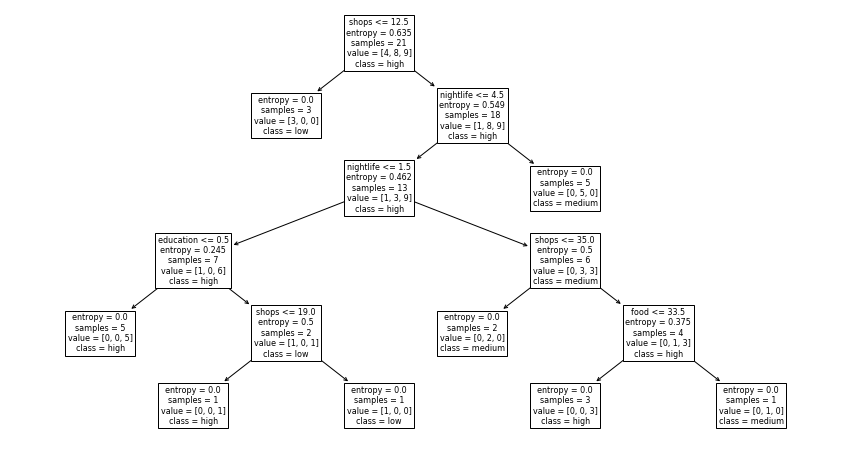

In [25]:
plt.figure(figsize=[15, 8])
tree.plot_tree(clf, feature_names=features.columns.tolist(), class_names=['low', 'medium', 'high'], fontsize=8)

# Discussion

From the decision tree diagram, we found that the presence of shops took the top position in predicting if a coffee shop will get high business or not, and followed by nightlife. 

The bottom node with 5 samples of "high" (most left) is a pure node with highest number of high traffic. If we follow the path to get there, we come up with the following criteria:
1. If the number of nearby shops >= 13, and
2. number of nearby nightlife venues >= 5, and
3. number of nearby education venues >= 1, then the customer traffic will be high

It is quite easy to understand the above finding as we relate with real-life situation. If a coffee shop is surrounded by many shops, near nightlife attractions and a college, then it will definitely attract a wide spectrum of customers from daytime shoppers, night goers and students.


**So, how can we actually use this information to decide on a new shop location?**</br>
Well, one way to do it is by using the Foursquare data to search for all locations of shops, nightlife, and education in a given neighborhood. The data will be quite large to download but this should be computationally pretty fast to process. Then, we could apply k-means clustering to find clusters which satisfy our neighborhood requirements and place a coffee shop there.

We can further improve the accuracy by collecting more coffee shops data around KL, cleaning up the neighbors data from erroneous venues, and using other sources such as Google Maps. We kept the scope of this study small and within the free services provided by Foursquare. 

# Conclusion
In this study, we have looked at some data from coffee shops in Kuala Lumpur to identify combination of factors that may help a business owner to decide where to place a new coffee shop so that it will receive high business traffic. The results were based on some limited data as provided by Foursquare in the form of location, customer ratings, and neighboring venues. We found several instances of inaccuracies in the Foursquare data. Despite the limitations with the data, the result of decision tree prediction gives a reasonable answer as to why certain coffee shops are more successful than others. Among the important factors are the presence of nearby shops, nightlife attractions, and education institutions. 